In [ ]:
import pandas as pd
import numpy as np
np.seterr(all='warn')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sales_of_company = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv", index_col='Month')
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv",  index_col='Month')
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv",  index_col='Month')
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv",  index_col='Month')
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv",  index_col='Week')
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv",  index_col='Date')

# Постоение рядов, оценка стационарности и выделение 2-х рядов для дальнейшей работы

In [ ]:
ts_dict = {'sales_of_company': sales_of_company, 
           'robberies_in_boston': robberies_in_boston,
           'airlines_passengers': airlines_passengers,
           'mean_monthly_temp': mean_monthly_temp,
           'dowjones_closing': dowjones_closing,
           'female_births': female_births}

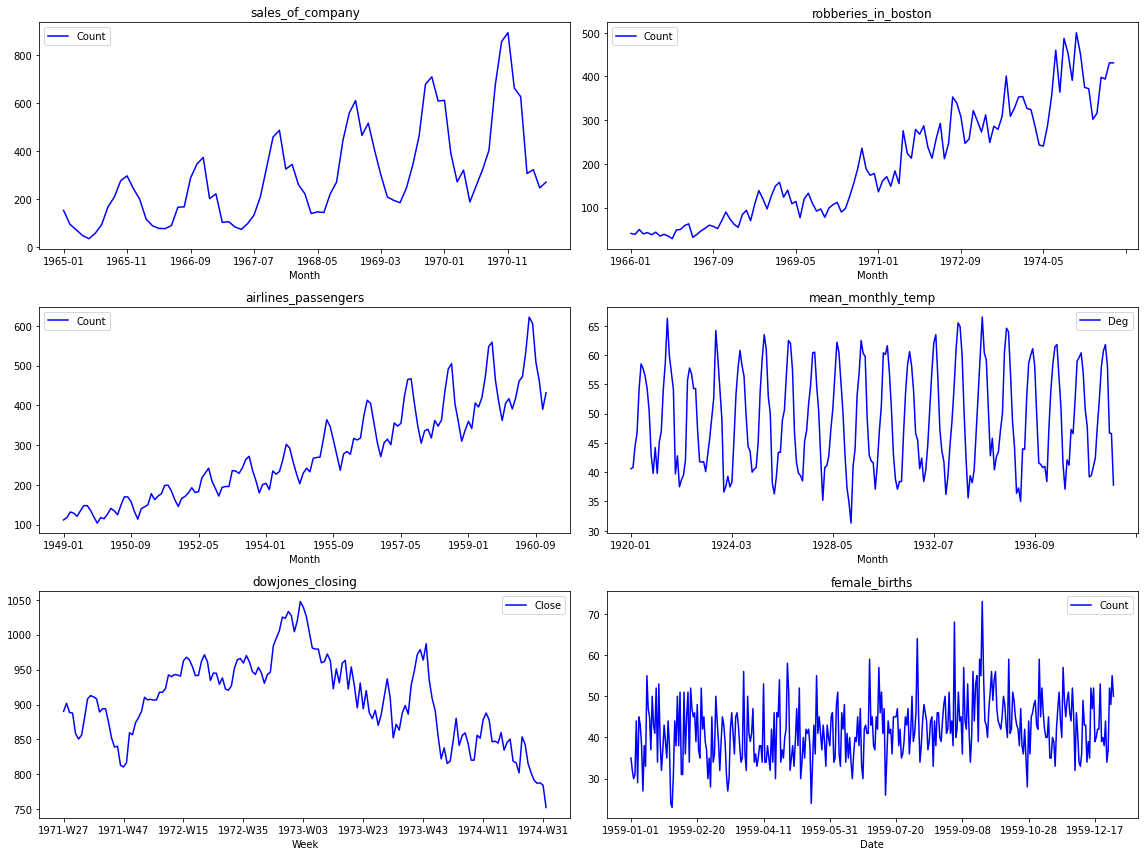

In [ ]:
plt.figure(figsize=(16, 12))
layout = (3, 2)
for i, key in enumerate(ts_dict.keys()):
    x = i % 2
    y = int((i - x) / 2)
        
    ts_ax = plt.subplot2grid(layout, (y, x))
    ts_dict[key].plot(ax=ts_ax, color='blue')
    ts_ax.set_title(key)
        
plt.tight_layout()

In [ ]:
def df_test(ts_dict):
  for key, value in ts_dict.items():
    p_value = adfuller(value, autolag='AIC')
    if p_value[1] > 0.05:
      print(f'Series: {key}, P value: {p_value[1]}, не отвергают гипотезу о нестационарности ряда')
    else:
      print(f'Series: {key}, P value: {p_value[1]}, отвергают гипотезу, ряд - стационарный')

In [ ]:
df_test(ts_dict)

Series: sales_of_company, P value: 0.9888894205170052, не отвергают гипотезу о нестационарности ряда
Series: robberies_in_boston, P value: 0.9942775638057231, не отвергают гипотезу о нестационарности ряда
Series: airlines_passengers, P value: 0.991880243437641, не отвергают гипотезу о нестационарности ряда
Series: mean_monthly_temp, P value: 0.016989030222608947, отвергают гипотезу, ряд - стационарный
Series: dowjones_closing, P value: 0.6224548515589733, не отвергают гипотезу о нестационарности ряда
Series: female_births, P value: 5.2434129901498554e-05, отвергают гипотезу, ряд - стационарный


In [ ]:
ts_dict_new = {'sales_of_company': sales_of_company, 
               'female_births': female_births}

# Скользящее среднее для обоих рядов


In [ ]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)

    return series.rolling(n).mean()

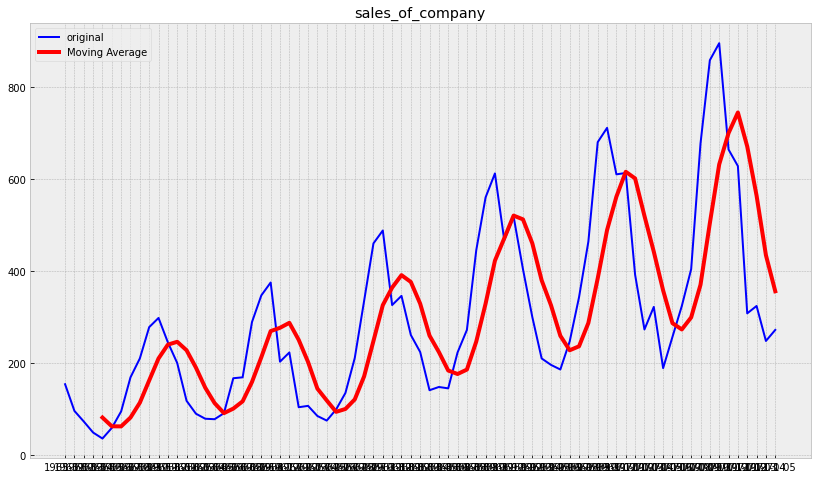

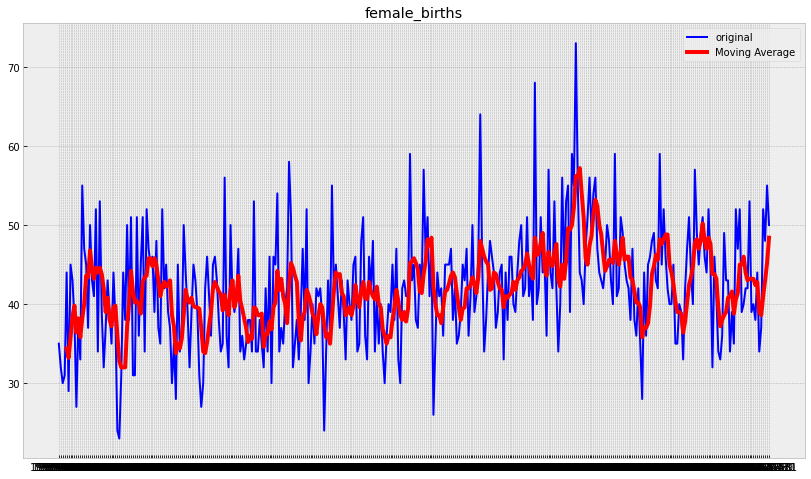

In [ ]:
for key, value in ts_dict_new.items():
  with plt.style.context('bmh'):
      plt.figure(figsize=(14, 8))
      plt.plot(value['Count'], color='blue',label='original')
      plt.plot(moving_average(value['Count'], 5), color='red', linewidth='4', label='Moving Average')
      plt.title(key)
      plt.legend()

# Экспоненциальное сглаживание для нестационарного ряда

In [ ]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return series.append(pd.Series(predictions), ignore_index=True)

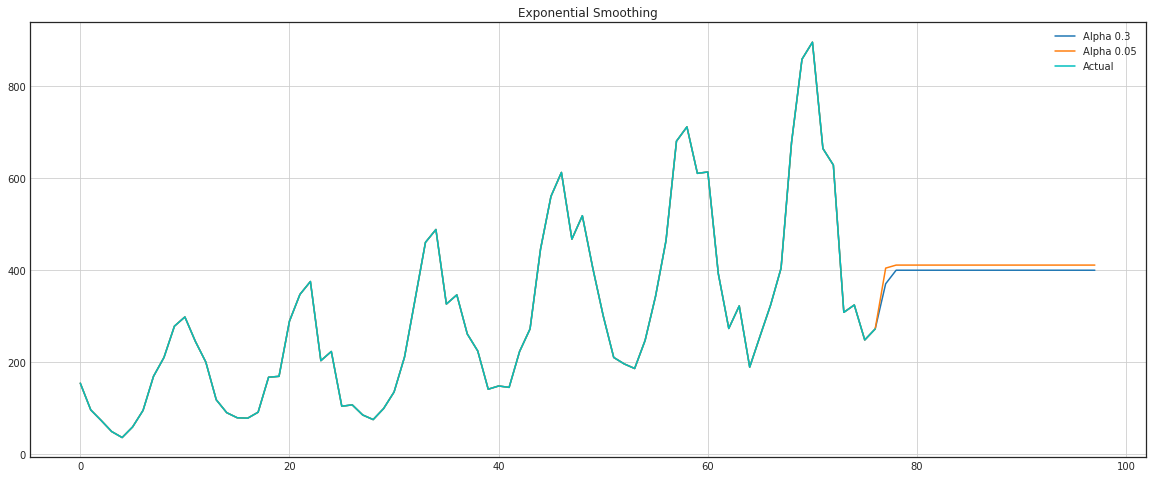

In [ ]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_moving_average(ts_dict_new['sales_of_company']['Count'], alpha, 20), label="Alpha {}".format(alpha))
    plt.plot(ts_dict_new['sales_of_company']['Count'].values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

# Экспоненциальное сглаживание для стационарного ряда

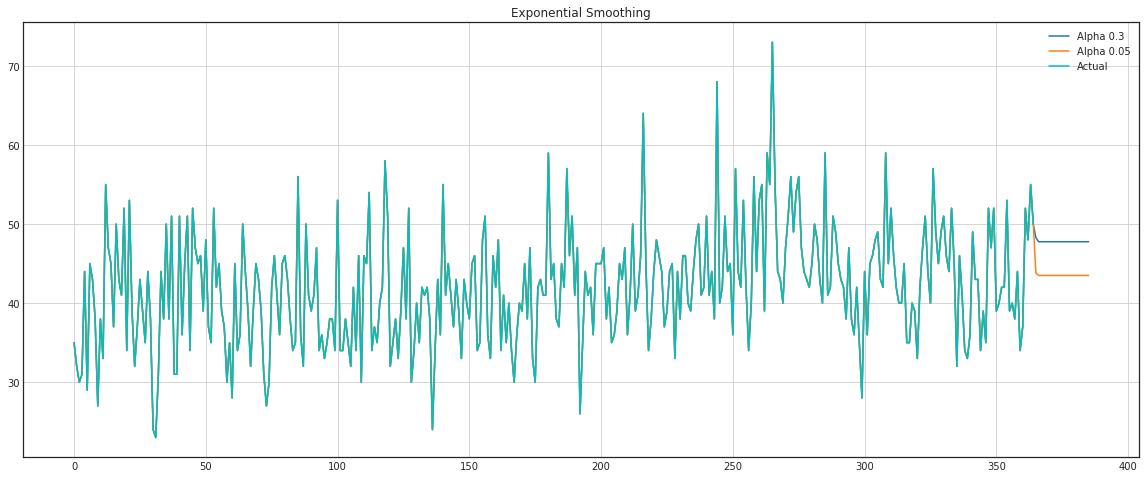

In [ ]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_moving_average(ts_dict_new['female_births']['Count'], alpha, 20), label="Alpha {}".format(alpha))
    plt.plot(ts_dict_new['female_births']['Count'].values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

Видим, что простое сглаживание дает совершенно ненормальное предсказание

# Модель Хольта-Винтерса для нестационарного ряда

In [ ]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [ ]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [ ]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [ ]:
def plot_tema(alpha, beta, gamma, ser=ts_dict_new['sales_of_company']["Count"], ser_to_plot=ts_dict_new['sales_of_company']["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

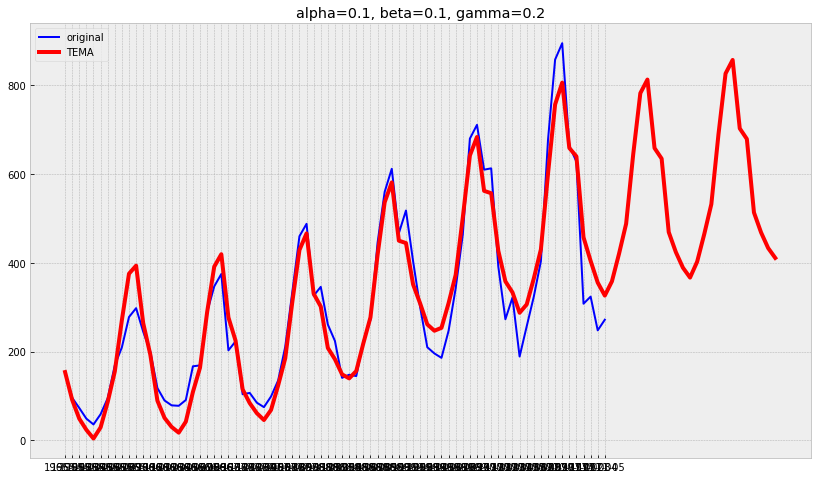

In [ ]:
plot_tema(0.1, 0.1, 0.2)

Результат гораздо лучше чем от простого сглаживания

# Модель Хольта-Винтерса для стационарного ряда

In [ ]:
def plot_tema(alpha, beta, gamma, ser=ts_dict_new['female_births']["Count"], ser_to_plot=ts_dict_new['female_births']["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

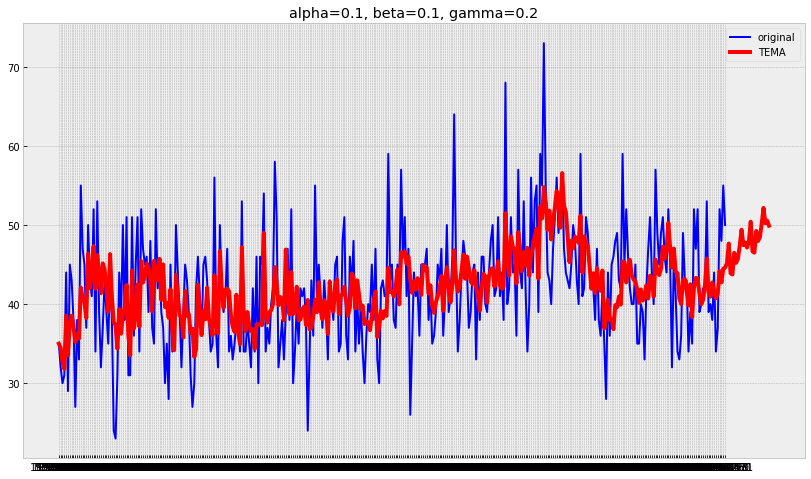

In [ ]:
plot_tema(0.1, 0.1, 0.2)

# Встроенные методы

In [ ]:
train, test = ts_dict_new['sales_of_company']['Count'].values[:50], ts_dict_new['sales_of_company']['Count'].values[50:]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


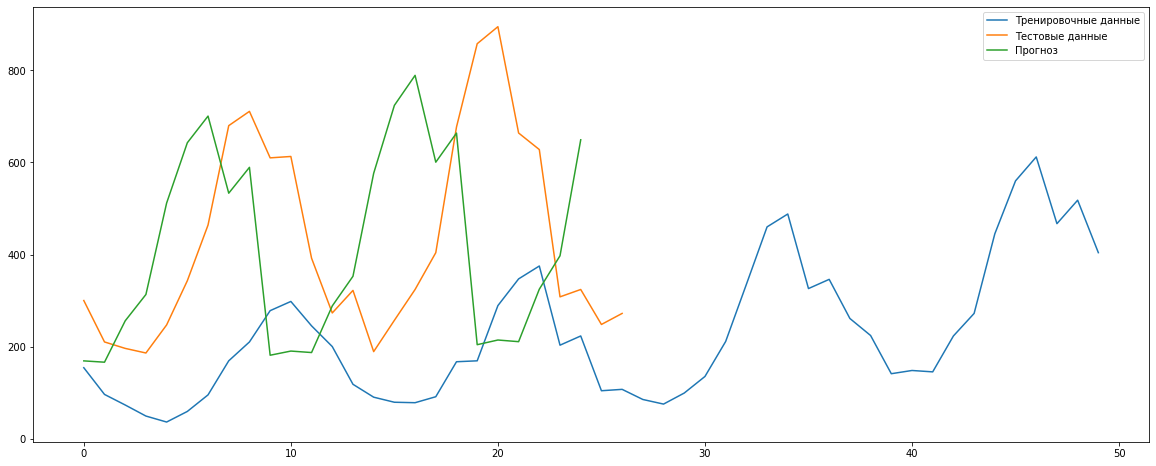

In [ ]:
fitted_model = ExponentialSmoothing(train, trend = 'multiplicative', seasonal = 'multiplicative', seasonal_periods = 10).fit()
test_predictions = fitted_model.forecast(25)
plt.figure(figsize=(20, 8));
pd.Series(train).plot(legend = True, label = 'Тренировочные данные');
pd.Series(test).plot(legend = True, label = 'Тестовые данные');
pd.Series(test_predictions).plot(legend = True, label = 'Прогноз');

In [ ]:
train1, test1 = ts_dict_new['female_births']['Count'].values[:300], ts_dict_new['female_births']['Count'].values[300:]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


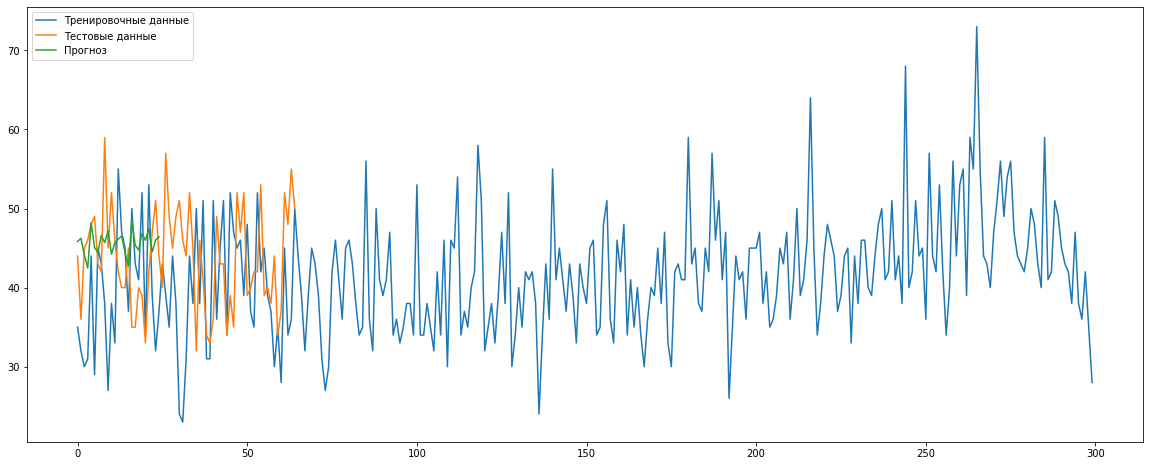

In [ ]:
fitted_model1 = ExponentialSmoothing(train1, trend = 'multiplicative', seasonal = 'multiplicative', seasonal_periods = 12).fit()
test_predictions1 = fitted_model1.forecast(25)
plt.figure(figsize=(20, 8));
pd.Series(train1).plot(legend = True, label = 'Тренировочные данные');
pd.Series(test1).plot(legend = True, label = 'Тестовые данные');
pd.Series(test_predictions1).plot(legend = True, label = 'Прогноз');